In [ ]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost_order import process_kline, inference
from helper import get_binance_ohlc_time, generate_date_list, calculate_rsi_with_ema, is_decrease, is_pin_bar, generate_df_klines
import random
TRAINING = False
INFERENCE_XG = False

In [323]:
def rule(df_btc, df, tp=1, sl=5, money=1000, model = None, num_random=10000, window_test=10, seq=30, time_pred=10, manual_cond=False):
    dfcopy = df.copy()
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []

    index_condition = []
    pick_index = []

    if model is None:
        index_condition = random.sample(range(100, len(df)), num_random)
        index_condition.sort()
        #and df.iloc[i-2]['close'] >= df.iloc[i-2]['open'] and  df.iloc[i-3]['close'] >= df.iloc[i-3]['open']
        for i in index_condition:
            if df.iloc[i-1]['Trend'] == 1:
                pick_index.append(i)
    else:
        for i in range(seq+1, len(df)-1, window_test):
            x_array = df.loc[i-seq:i-1, ["open", "high", "low", "close", "volumn"]].to_numpy()
            x_array_cp = x_array.copy()
            rsi_6 = calculate_rsi_with_ema(x_array, 6)
            y_pred_prob = inference(x_array, model)
            if y_pred_prob == 1:
                if manual_cond:
                    # if is_decrease(x_array_cp[-1]) or is_decrease(x_array_cp[-2]) or is_pin_bar(x_array_cp[-1]): 
                    if rsi_6[-1] > 20 and rsi_6[-2] > 20:
                        index_condition.append(i)
                else:
                    index_condition.append(i)
        index_condition = sorted(index_condition)
    # print([i[0] for i in pick_index])
    for i in pick_index:
        open_price_i = df['open'].iloc[i]
        high_check = False
        low_check = False
        open_time = df.iloc[i]['timestamp']
        if time_pred == "all":
            end = len(df)
        else:
            end = i+time_pred
        for j in range(i,end):
            if j >= len(df):
                break
            low_sma = df['low'].iloc[j] < df['lower'].iloc[j]
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * open_price_i
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * open_price_i
            opentime_j = df['timestamp'].iloc[j]
            low_sma = False
            if low_sma:
                print(open_time, "low sma")
                pnl = money * (1 - df['lower'].iloc[j] / open_price_i)
                balance += pnl
                list_reward.append(balance)
                results.append((i, open_time,j,open_price_i, "sma", round(pnl,2)))
                number_low+=1
                low_check = True
                break
            if (high_check and low_check) or (high_check and low_sma):
                print(open_time, "check lai at", opentime_j)
                list_reward.append(list_reward[-1])
                break
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, open_time,j, opentime_j,open_price_i, "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i])
                # print("low", j-i)
                results.append((i, open_time,j, opentime_j, open_price_i, "low"))
                break
        if not high_check and not low_check and j<len(df):
            if df.iloc[j]['close'] < open_price_i:
                pnl = money * (1 - df.iloc[j]['close'] / open_price_i)
                balance += pnl
            else:
                pnl = -money * (df.iloc[j]['close'] / open_price_i-1)
                balance += pnl
            list_reward.append(balance)
            price_line.append(j)
            results.append((i, open_time,j, "not",open_price_i, df.iloc[j]['close'], round(pnl, 2)))
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)

    return results, pick_index, number_high, number_low, list_reward, prices_list

# Inference


In [ ]:
if INFERENCE_XG:
    bst = xgb.Booster()
    bst.load_model('./weights/ORDIUSDT_15m_tp3_sl3_60pcent_mancond_fapiv1.json')


In [ ]:
threshold = 0.01

def classify_trend(row):
    if pd.isna(row['SMA']):
        return None  # Không đủ dữ liệu để phân loại
    elif row['close'] > row['SMA'] * (1 + threshold):
        return 2
    elif row['close'] < row['SMA'] * (1 - threshold):
        return 1
    else:
        return 0
    
def classify_trend_through(row):
    if pd.isna(row['SMA']):
        return None  # Không đủ dữ liệu để phân loại
    elif row['close'] < row['SMA'] * (1 - threshold) and row['open'] > row['SMA']:
        return 1
    else:
        return 0
    
def out_boll_4h(row):
    att = row['close'] - row['open']
    if pd.isna(row['upper']):
        return None  # Không đủ dữ liệu để phân loại
    
    elif att > 0 and row['open'] + att * 0.4 < row['upper'] < row['open'] + att * 0.8:

    # elif att > 0 and row['upper'] < row['open'] + att * 0.8:
    # elif att < 0 and row['open'] + att * 0.4 > row['lower'] > row['open'] + att * 0.8:

        return 1
    else:
        return 0
    
    
def classify_trend_bollband(row):
    if pd.isna(row['upper']):
        return None  # Không đủ dữ liệu để phân loại
    elif (row['low'] + row['high'])/2 > row['upper']:
        return 1
    elif (row['low'] + row['high'])/2 < row['lower']:
        return 2
    else:
        return 0



In [ ]:
C98, LDO, ORDI, DYDX

In [ ]:
df_all, csv_link = generate_df_klines(start = "2023-03-10", end = "2025-03-20", symb = "ORDIUSDT", interval = "15m", split_day=4)

In [324]:
print(csv_link)
# df_all = pd.read_csv(csv_link)
# df_all = pd.read_csv("data_his/LDOUSDT_2023-03-10_2025-03-20_4h_fapiv1.csv")
# df_all = pd.read_csv("data_his/C98USDT_2023-03-10_2025-03-20_4h_fapiv1.csv")
# df_all = pd.read_csv("data_his/DYDXUSDT_2023-03-10_2025-03-20_4h_fapiv1.csv")
df_all = pd.read_csv("data_his/ORDIUSDT_2023-03-10_2025-03-20_4h_fapiv1.csv")
# df_all = pd.read_csv("data_his/ORDIUSDT_2023-03-10_2025-03-20_15m_fapiv1.csv")
# df_all = df_all.iloc[3:].reset_index()
# group_size = 16
# df_new = df_all.groupby(df_all.index // group_size).agg({
#     "timestamp":"first",
#     "open": "first",
#     "high": "max",
#     "low": "min",
#     "close": "last"
# }).reset_index(drop=True)

# df_all = df_new

df_all['SMA'] = df_all['close'].rolling(window=30).mean()
df_all['SMA20'] = df_all['close'].rolling(window=20).mean()
df_all['std'] = df_all['close'].rolling(window=20).std()
df_all['upper'] = df_all['SMA20'] + 2 * df_all['std']
df_all['lower'] = df_all['SMA20'] - 2 * df_all['std']

df_all['Trend'] = df_all.apply(out_boll_4h, axis=1)

# df_all = df_all.iloc[-20000:].reset_index()
display(df_all.head(1))
display(df_all.tail(2)) 

rs2, idcond, high_check, low_check, list_reward, prices_list = rule(df_all, df_all, tp=10, sl=10,window_test=1,num_random=2800, model=None, seq=30, time_pred="all",manual_cond=False)
print(len(rs2))
list_reward[-1] 


data_his/ORDIUSDT_2023-03-10_2025-03-20_15m_fapiv1.csv


,timestamp,open,high,low,close,volumn,SMA,SMA20,std,upper,lower,Trend
0,2023-11-07 19:00:00,10.516,10.72,9.91,10.126,6472777.4,NaN,NaN,NaN,NaN,NaN,NaN


,timestamp,open,high,low,close,volumn,SMA,SMA20,std,upper,lower,Trend
2988,2025-03-19 19:00:00,9.478,9.536,9.294,9.456,1180627.4,9.249633,9.26460,0.235736,9.736072,8.793128,0.0
2989,2025-03-19 23:00:00,9.457,9.837,9.214,9.691,1840674.0,9.266133,9.29755,0.247286,9.792122,8.802978,0.0


num points:  2800 number_low/all_point 0.6 cannot_break 0
65


1300.0

In [325]:
rs2

[(142, '2023-12-01 11:00:00', 147, '2023-12-02 07:00:00', 21.307, 'high'),
 (144, '2023-12-01 19:00:00', 147, '2023-12-02 07:00:00', 21.35, 'high'),
 (160, '2023-12-04 11:00:00', 163, '2023-12-04 23:00:00', 42.191, 'high'),
 (165, '2023-12-05 07:00:00', 165, '2023-12-05 07:00:00', 52.296, 'low'),
 (170, '2023-12-06 03:00:00', 172, '2023-12-06 11:00:00', 63.929, 'low'),
 (222, '2023-12-14 19:00:00', 222, '2023-12-14 19:00:00', 62.466, 'low'),
 (262, '2023-12-21 11:00:00', 263, '2023-12-21 15:00:00', 57.999, 'low'),
 (287, '2023-12-25 15:00:00', 287, '2023-12-25 15:00:00', 60.352, 'high'),
 (291, '2023-12-26 07:00:00', 291, '2023-12-26 07:00:00', 75.363, 'high'),
 (320, '2023-12-31 03:00:00', 327, '2024-01-01 07:00:00', 82.761, 'low'),
 (336, '2024-01-02 19:00:00', 341, '2024-01-03 15:00:00', 88.506, 'low'),
 (376, '2024-01-09 11:00:00', 380, '2024-01-10 03:00:00', 75.905, 'low'),
 (484, '2024-01-27 11:00:00', 494, '2024-01-29 03:00:00', 59.297, 'low'),
 (501, '2024-01-30 07:00:00', 528,

In [327]:
prices_list = []
balances = [0]
pos_get = [i for i in idcond]
for i in range(len(df_all)):
    prices_list.append(df_all.iloc[i]['close'])
    if i in pos_get:
        ind = pos_get.index(i)
        balances.append(list_reward[ind])
    else:
        balances.append(balances[-1])


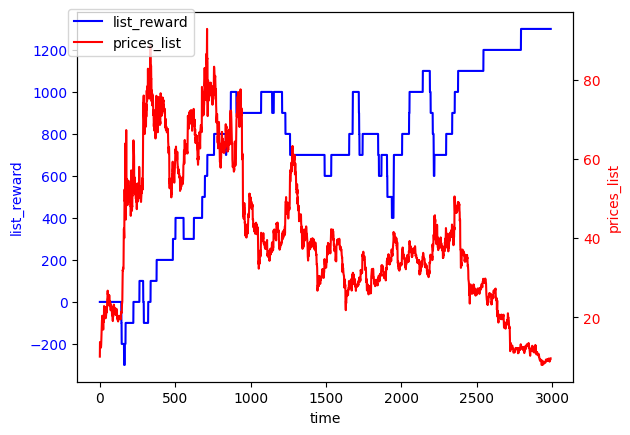

In [328]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(balances, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')


fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()

# Training XGBOOST

In [ ]:
# Training XGBoost
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        
        min_vol = np.min(x_array[:,-1])
        max_vol = np.max(x_array[:,-1])
        if min_vol == 0:
            continue

        # x_array[:,-1] = (x_array[:,-1]-min_vol)/(max_vol-min_vol)
        x_array[:,-1] = x_array[:,-1]/min_vol

        min_price = np.min(x_array[:,:4])
        max_price = np.max(x_array[:,:4])
        x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)
        x.append(x_array)

        if point[-1] == "low":
            y.append(1)
        elif point[-1] == "high":
            y.append(2)
        else:
            y.append(0)
    return x, y

if TRAINING:
    df_all = pd.read_csv("data_his/TIAUSDT_2024-08-16_2025-03-18_15m_fapiv1.csv")
    df = df_all.iloc[:20000].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
    display(df.head(1))
    display(df.tail(2))
    rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3,time_pred=10, num_random=10000, seq=30)


    x, y = create_dataset(df_all, rs, 40)
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(x.shape[0], -1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)


    param = {
        'max_depth': 25,
        'eta': 0.1,
        'objective': 'multi:softmax',  # Multiclass classification
        'num_class': 3,                # Number of classes
        'eval_metric': 'merror'       # Multiclass classification error rate
    }
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]

    # Train the model
    num_round = 50
    bst = xgb.train(param, dtrain, num_round, evals=watchlist, verbose_eval=False)

    # Make predictions
    y_pred_prob = bst.predict(dtest)
    y_pred = y_pred_prob.astype(int) # Convert predicted probabilities to class labels

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)

    print("Precision per class:", precision)
    print("Recall per class:", recall)
    print("F1-score per class:", f1)

    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print("\nWeighted Precision:", precision_weighted)
    print("Weighted Recall:", recall_weighted)
    print("Weighted F1-score:", f1_weighted)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Not', 'Down', "Up"])
    cmd.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()